# DICOM Processing Script

*Summary:* Take DICOM images and process them for use in neon models.

NOTES:
+ [DICOM](https://en.wikipedia.org/wiki/DICOM) stands for "Digital Imaging and COmmunication in Medicine". It is the standard for all medical imaging from MRI to CT to Ultrasound to whatever. 
+ The standard was created so that devices manufacturers would have a common format for hospitals to integrate into their digital imaging systems. That's good for us because it gives us a standard way to load and process many types of medical images. If we can get a good pipeline going, then this script might be useful in many medical imaging studies.
+ MRI and CT are stored as 2D slices which can be combined to form a 3D volume. So for any given patient we may have several hundred slice files that correspond to the same scan. This is different than most of our image data models because we need to incoporate all of these slices into one tensor. We definitely want to use the 3D volume because things like tumors and lesions (and other bad things that cause illness) don't limit themselves to a single 2D slice. Therefore, we've got to load this into our model as a 4D tensor (height, width, depth, channel). 
+ The slice thickness varies but is typically 1 to 3 mm. It depends on the type of study (MR/CT) and the parameters set at the start of the scan. Be sure to get a good handle on the height, width, and depth parameters of the DICOM files so that you are importing consistent tensors into the data loader. This is something I need to look into because ideally we'd like to standardize the tensors (for example, 1 mm x 1 mm x 1 mm voxels or something like that). 
+ The pixels are usually stored as uint16 precision. I'm not sure if we need to change that to something with less precision. If we can keep the full 16-bit precision, then that would be preferable. There may in fact be anomalies that involve a very minor difference in the contrast between two adjacent regions. This is an open question for analysis.
+ Along with the actual pixel information, the DICOM file also contains lots of metadata, such as slice thickness, pixel resolution, image orientation, and type of study (i.e. MRI, CT, X-ray).
+ This assumes that your DICOM images are stored in DATA_DIR. Within DATA_DIR there should be a separate folder for each subjects scans. The files usually end in the .dcm extension (e.g. 0a291d1b12b86213d813e3796f14b329.dcm might be one slice for one patient). The SimpleITK library we use will load slices within a given patient's directory all at once into a 3D object.

In [1]:
from matplotlib import pyplot as plt, cm
import numpy as np
import cv2 
import glob, os

%matplotlib inline

## SimpleITK for reading DICOM

[SimpleItk](http://www.simpleitk.org/) is an open-source library for reading and processing 3D models. It was particularly designed for medical imaging and was built on top of the Insight and Segmentation and Registration (ITK) toolkit sponsored by the National Library of Medicine.

What's nice about SimpleITK is that it has pre-built methods to read all of the DICOM slices into a 3D object and perform segmentation and morphological operations on that 3D object. I believe it automatically arranges the slices in the correct order. It also can handle compressed DICOM files.

In [2]:
#!pip install SimpleITK
import SimpleITK as sitk

## Ask the system how many patients are in the data directory.

Typically the DICOM files for each patient are stored in a different sub-directory.

In [3]:
DATA_DIR = "/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/"
    
patients = glob.glob(os.path.join(DATA_DIR, '*')) # Get the folder names for the patients

if len(patients) == 0:
    raise IOError('Directory ' + DATA_DIR + ' not found or no files found in directory')
    
print('Found the following subfolders with DICOMs: {}'.format(patients))

Found the following subfolders with DICOMs: ['/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/0030a160d58723ff36d73f41b170ec21', '/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/0092c13f9e00a3717fdc940641f00015', '/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/00cba091fa4ad62cc3200a657aeb957e', '/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/00edff4f51a893d80dae2d42a7f45ad1', '/Volumes/homes/users/anthony.reina/dicom/Lung CT/stage1/013395589c01aa01f8df81d80fb0e2b8']


## Set up a pipeline for reading all DICOM images for one patient at a time

SimpleITK has a pipeline for reading all of the DICOM slices for one patient into one object. So we'll essentially have a 3D array with the pixel values from every slice for this patient.

In [4]:
for patientDirectory in patients[:1]:  # TODO: Go through just one patient for testing. Later we'll use the whole loop
    
    # The next 4 lines set up a SimpleITK DICOM reader pipeline.
    reader = sitk.ImageSeriesReader()
    # Now get the names of the DICOM files within the directory
    filenamesDICOM = reader.GetGDCMSeriesFileNames(patientDirectory)
    reader.SetFileNames(filenamesDICOM)
    # Now execute the reader pipeline
    patientObject = reader.Execute()
    

## patientObject description

Now patientObject is a SimpleITK object which includes the 3D array of the pixels for this patient's DICOM. Let's print out some of the meta values to get a sense of the DICOM information.

In [28]:
print('This is a {} dimensional image'.format(patientObject.GetDimension()))
print('There are {} slices for this patient.'.format(patientObject.GetDepth()))
print('Each slice is {} H x {} W pixels.'.format(patientObject.GetHeight(), patientObject.GetWidth()))
print('The real world size of these pixels (i.e. voxel size) is {} mm H x {} mm W x {} mm D [slice thickness]'.
     format(patientObject.GetSpacing()[0], patientObject.GetSpacing()[1], patientObject.GetSpacing()[2]))
print('The real world origin for these pixels is {} mm. This helps us align different studies.'.format(patientObject.GetOrigin()))

This is a 3 dimensional image
There are 265 slices for this patient.
Each slice is 512 H x 512 W pixels.
The real world size of these pixels (i.e. voxel size) is 0.582031 mm H x 0.582031 mm W x 1.25 mm D [slice thickness]
The real world origin for these pixels is (-139.10000610351562, -135.5, -337.43499755859375) mm. This helps us align different studies.


## Helper function for displaying images

This is just a helper function to properly display our figures in matplotlib. I modified it from this website:
https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/
    


In [36]:
def sitk_show(img, title=None, margin=0.05, dpi=40):
    
    # Here we are just converting the image from sitk to a numpy ndarray
    ndArray = sitk.GetArrayFromImage(img)
    
    spacing = img.GetSpacing() # This returns the realworld size of the pixels (in mm)
    figsize = (1 + margin) * ndArray.shape[0] / dpi, (1 + margin) * ndArray.shape[1] / dpi
    extent = (0, ndArray.shape[1]*spacing[1], ndArray.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap(cm.bone)  # TODO: This might be specific to CT scans(?)
    ax.imshow(ndArray,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

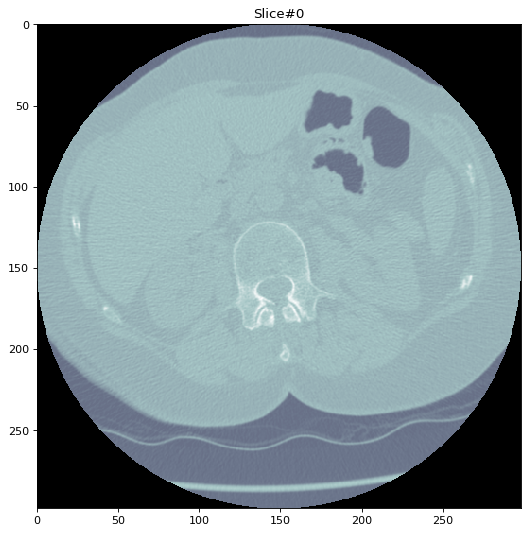

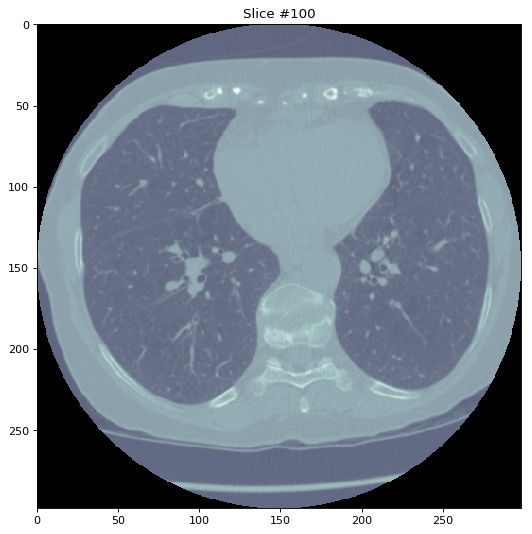

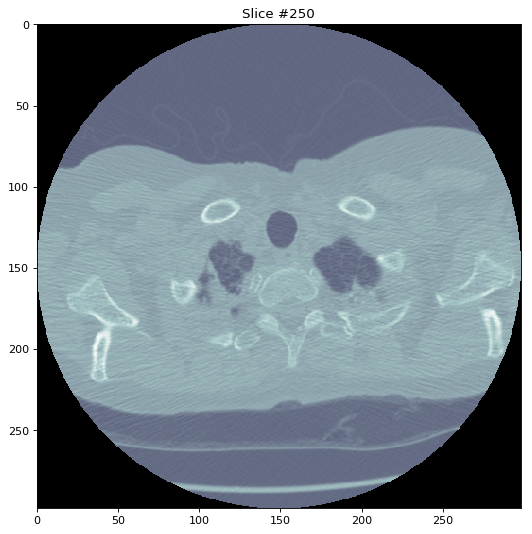

In [49]:
sitk_show(patientObject[:,:,0], title='Slice#0', dpi=80)  # Display slice 0
sitk_show(patientObject[:,:,100], title='Slice #100', dpi=80) # Display slice 100
sitk_show(patientObject[:,:,250], title='Slice #250', dpi=80) # Display slice 250